In [13]:
%matplotlib inline                  
from nptdms import TdmsFile           # Handling TDMS files
import matplotlib.pyplot as plt
import numpy as np
import time
import os
plt.rcParams.update({'font.size': 14})
import matplotlib.cm as cm
import statistics as stats

# Load the Trajectory

In [14]:
filenumber = 21
folder = "/Users/alex/Documents/Measurements/201210 - Alex 2 particles"

pxtomum=0.0533
R = 2.19e-6/2
diameter = R*2*1e6
start_time = time.time()   
if filenumber < 10: tdms_file = TdmsFile(folder+"/Test_00"+str(filenumber)+"_module.tdms")
else:
    if filenumber < 100: tdms_file = TdmsFile(folder+"/Test_0"+str(filenumber)+"_module.tdms")
    else: filetdms_file = TdmsFile(folder+"/Test_"+str(filenumber)+"_module.tdms")
print("--- %s seconds ---" % round((time.time() - start_time),2))

Xc = tdms_file['Data']['Xc']
Yc = tdms_file['Data']['Yc']
xolaser = tdms_file['Data']['Xh']
yolaser = tdms_file['Data']['Yh']
Nfound = tdms_file['Data']['N']
Nlaser = tdms_file['Data']['NLaser']

phase = tdms_file['Data']['Phase']
p = tdms_file.object().properties
dt = p['CycleTime']
boundaryradius = p['Boundary']
delay = int(p['Delay'])
noise = int(p['Sigmanoise'])
offset = -p['Offset']
videosize = p['Xsize']
firstlength = len(Nfound)
maxlength = 0
for i in range(firstlength):
    if phase[i] == 0: maxlength += 1

print('size of the video = ',videosize)
print('length of the movie = ',maxlength)

--- 12.13 seconds ---
size of the video =  800
length of the movie =  10000


/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.object' is deprecated and will be removed in a future release. Use TdmsFile.properties to access properties of the root object, TdmsFile[group_name] to access a group object and TdmsFile[group_name][channel_name] to access a channel object.
  warnings.warn(message)
/Users/alex/anaconda/lib/python3.5/site-packages/nptdms/tdms.py:1097: UserWarning: 'TdmsFile.objects' is deprecated and will be removed in a future release. Use TdmsFile.groups() to access all groups in the file, and group.channels() to access all channels in a group.
  warnings.warn(message)


# Sort the trajectory

Trajectory length
[9998. 9998.]


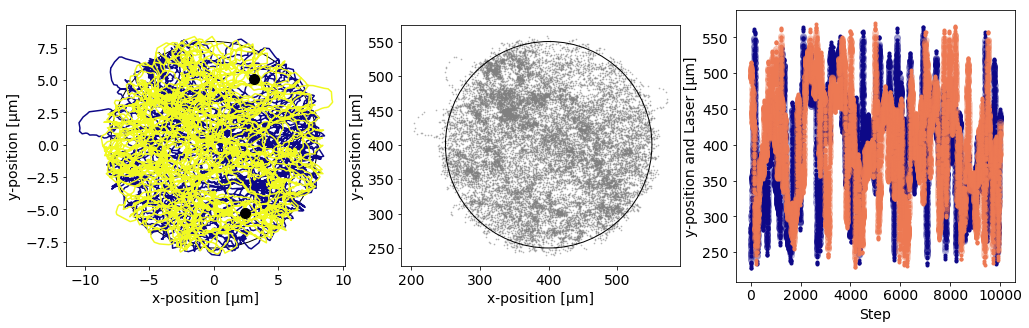

In [15]:
pnumber = int(stats.mode(Nfound))
maxnumber = int(max(Nfound))
particles = np.zeros((maxlength,pnumber,8))
lastone = np.zeros((pnumber,2))
pre = np.zeros((maxlength,maxnumber,8))
test = np.zeros((int(Nfound[0]),2))
for i in range(int(Nfound[0])):             #Sort the particles in the first frame according to there 
    test[i,0] = i                           #distance to the center, particles outside the boundary are not important
    test[i,1] = np.sqrt(pow(Xc[i]-videosize/2,2)+pow(Yc[i]-videosize/2,2))
check = sorted(test, key=lambda test: test[1])
order = np.zeros(int(Nfound[0]))
for i in range(int(Nfound[0])):
    test2 = check[i]
    order[i] = test2[0]  
count = 0
for j in range(int(Nfound[0])):
    pre[0,j,0] = Xc[int(order[j])]
    pre[0,j,1] = Yc[int(order[j])]
    #pre[0,j,2] = velocitytheo[int(order[j])]
    #pre[0,j,3] = angletheo[int(order[j])] 
    pre[0,j,4] = xolaser[int(order[j])]
    pre[0,j,5] = yolaser[int(order[j])]
    #pre[0,j,6] = intensitytheo[int(order[j])]           
count = int(Nfound[0])
for i in range(1,maxlength):               #Write all position in a first wave
    for j in range(int(Nfound[i])):
        pre[i,j,0] = Xc[count]
        pre[i,j,1] = Yc[count]
        #pre[i,j,2] = velocitytheo[count]
        #pre[i,j,3] = angletheo[count]
        pre[i,j,4] = xolaser[count]
        pre[i,j,5] = yolaser[count]
        #pre[i,j,6] = intensitytheo[count]
        count += 1
        
sumup = Nfound[0]                         #sumup - if the first frames are without a particle, they willbe cut off
if Nfound[0] != 0: starttraj = 0
particles[0,:,:] = pre[0,:pnumber,:]
diff = 0
for i in range(1,maxlength):
    if sumup != 0:
        check = False; occupied = np.zeros((int(Nfound[i]),2))
        for p in range(2):                    #first check those particles which where found in the frame before
            for j in range(pnumber):
                if p == 0:
                    if particles[i-1,j,0] != 0: check = True
                else:
                    if particles[i-1,j,0] == 0: check = True          
                if check == True:         
                    sumup += Nfound[i]
                    if particles[i-1,j,0] != 0:    #remember how long the particle is lost
                        lastone[j,0] = i-1
                        lastone[j,1] = 0
                    else: lastone[j,1] += 1
                    xpre = particles[int(lastone[j,0]),j,0]
                    ypre = particles[int(lastone[j,0]),j,1]
                    mindist = 100; minnum = 666
                    for k in range(int(Nfound[i])):     #Sort the trajectories be comparing the distance between the positions
                        if occupied[k,0] == 0:
                            dist = np.sqrt(pow(xpre-pre[i,k,0],2)+pow(ypre-pre[i,k,1],2))
                            if dist < mindist:
                                mindist = dist
                                minnum = k
                    if minnum != 666:              #Write the shortest one
                        particles[i,j,:2] = pre[i,minnum,:2]
                        #particles[i,j,6] = pre[i,minnum,6]
                        occupied[minnum,0] = 1                 
                    mindist = 0.2; minnum = 666     #sort the laser position
                    for k in range(int(Nfound[i])):
                        if particles[i,j,0] != 0:
                            if occupied[k,1] == 0:
                                dist = np.sqrt(pow(particles[i-diff,j,0]-pre[i,k,4],2)+pow(particles[i-diff,j,1]-pre[i,k,5],2))
                                if abs(dist - offset) < mindist:
                                    mindist = dist
                                    minnum = k
                    if minnum != 666:              #Write the shortest one
                        particles[i,j,4:6] = pre[i,minnum,4:6]
                        occupied[minnum,1] = 1                           
    else:
        if Nfound[i] != 0:
            starttraj = i
            sumup += Nfound[i]
            for j in range(int(Nfound[i])): particles[i,j,:] = pre[i,j,:]

for i in range(1,maxlength):
    for j in range(pnumber):
        if particles[i,j,0] == 0:
            particles[i,j,0] = np.nan
            particles[i,j,1] = np.nan 
        if particles[i,j,4] == 0: 
            particles[i,j,4] = np.nan
            particles[i,j,5] = np.nan
particles[:,:,0:2] = (particles[:,:,0:2]-videosize/2)*pxtomum
particles[:,:,4:6] = (particles[:,:,4:6]-videosize/2)*pxtomum
save = particles.copy()
cutlastpoints = False
trajlength = np.zeros(pnumber)
for j in range(pnumber):
    lastfound = 0; out = True
    for i in range(starttraj+1,maxlength):
        if out == True:
            if particles[i,j,0] != particles[i,j,0]:
                lastfound = int(i-1)
                count = 1; check = True
                while check == True:
                    if lastfound+count < maxlength:
                        if particles[lastfound+count,j,0] == particles[lastfound+count,j,0]:
                            check = False
                        else: count +=1
                    else: count += 1 #= 150
                    if count == 200:
                        print('Failed at j = ',j,' - i = ',i)
                        check = False
                        trajlength[j] = lastfound
                        particles[lastfound:,j,0] = np.nan
                        particles[lastfound:,j,1] = np.nan
                        out = False
                if out == True:
                    for k in range(1,count+1):
                        particles[lastfound+k,j,0] = particles[lastfound,j,0]+(k/(count+1))*(particles[lastfound+count,j,0]-particles[lastfound,j,0])
                        particles[lastfound+k,j,1] = particles[lastfound,j,1]+(k/(count+1))*(particles[lastfound+count,j,1]-particles[lastfound,j,1])
                        #particles[lastfound+k,j,2] = particles[lastfound,j,2]+(k/(count+1))*(particles[lastfound+count,j,2]-particles[lastfound,j,2])
                        #particles[lastfound+k,j,3] = particles[lastfound,j,3]+(k/(count+1))*(particles[lastfound+count,j,3]-particles[lastfound,j,3])
                        #particles[lastfound+k,j,6] = particles[lastfound,j,6]+(k/(count+1))*(particles[lastfound+count,j,6]-particles[lastfound,j,6])
            if i == firstlength-2: 
                trajlength[j] = i
particlessave = particles.copy()
if starttraj != 0:
    maxlength = int(maxlength-starttraj)
    particles = np.zeros((maxlength,pnumber,6))
    particles = particlessave[starttraj:,:,:]
if cutlastpoints == True:
    particlessave = particles.copy()
    delete = firstlength - trajlength[0]
    maxlength = int(maxlength-delete)
    particles = np.zeros((maxlength,pnumber,6))
    particles = particlessave[:maxlength,:,:]
timewave=np.linspace(0,maxlength*dt,maxlength)
print('Trajectory length')                  
print(trajlength)

colorwave = cm.plasma(np.linspace(0, 1, pnumber))
fig=plt.figure(1, figsize = (17,5) )
ax = plt.subplot(1,3,1)
ax.set_aspect('equal')
for i in range(pnumber):
    ax.scatter(particles[starttraj,i,0],particles[starttraj,i,1],color='k',s = 100,zorder=3)
    ax.plot(particles[:,i,0],particles[:,i,1],color=colorwave[i],zorder=2)
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
ax.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')

ax2 = plt.subplot(1,3,2)
ax2.set_aspect('equal')
plt.scatter(Xc,Yc,s=0.5,color='grey',alpha = 0.5)
circle2 = plt.Circle((videosize/2, videosize/2), boundaryradius, color='k', fill=False)
ax2.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')

ax3 = plt.subplot(1,3,3)
xwave = np.linspace(0,maxlength,maxlength,endpoint=False)
colorwave = cm.plasma(np.linspace(0, 1, 2*pnumber))
for j in range(pnumber):
    ax3.scatter(xwave,pre[:,j,1],marker='o',c=colorwave[2*j],alpha=0.2)
    ax3.scatter(xwave,pre[:,j,5],marker='.',c=colorwave[2*j])
plt.xlabel('Step')
plt.ylabel('y-position and Laser [µm]')
plt.show()

In [16]:
100*dt

5.195999890565872

# Save a .png file of every frame from starthere to endhere in the folder MoviePic

In [18]:
starthere = 0
endhere = 1000

boundmum = boundaryradius*pxtomum
savefolder = '.'
factor =  1.3
for k in range(starthere,endhere):
    string_temp = savefolder + '/MoviePic/'
    if not os.path.exists(string_temp): os.makedirs(string_temp)
    fig=plt.figure(1, figsize = (5,5) )
    ax = plt.subplot(1,1,1)
    ax.set_aspect('equal')
    for i in range(pnumber):
        circle2 = plt.Circle((particles[k,i,0],particles[k,i,1]), R*1e6, color='grey', fill=False)
        ax.add_artist(circle2)
        circle2 = plt.Circle((particles[k,i,4],particles[k,i,5]), 0.2, color='green', fill=True)
        ax.add_artist(circle2)
    plt.xlabel('x-position [µm]')
    plt.ylabel('y-position [µm]')
    circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
    ax.add_artist(circle2)
    ax.set_title('t = '+str(round(k*dt,1))+' s')
    ax.set_xlim([-factor*boundmum,factor*boundmum])
    ax.set_ylim([-factor*boundmum,factor*boundmum])

    plt.savefig(string_temp +str(k)+'.png', format='png')
    plt.close(fig)

# Create a .mp4 Movie from the pictures

In [19]:
import moviepy.video.io.ImageSequenceClip
image_folder= string_temp
fps= 1/dt

image_files = []
for i in range(starthere,endhere):
    image_files.append(string_temp+str(i)+'.png')
    
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('Movie'+str(filenumber)+'.mp4')

t:   0%|          | 0/1000 [00:00<?, ?it/s, now=None]

Moviepy - Building video Movie21.mp4.
Moviepy - Writing video Movie21.mp4



Moviepy - Done !
Moviepy - video ready Movie21.mp4
